In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet/resnet101-63fe2227.pth
/kaggle/input/marineobjects/aquarium_pretrain/README.dataset.txt
/kaggle/input/marineobjects/aquarium_pretrain/README.roboflow.txt
/kaggle/input/marineobjects/aquarium_pretrain/data.yaml
/kaggle/input/marineobjects/aquarium_pretrain/valid/labels/IMG_2637_jpeg_jpg.rf.fb8a2e97a480a468812b0217a6fc5ce0.txt
/kaggle/input/marineobjects/aquarium_pretrain/valid/labels/IMG_2517_jpeg_jpg.rf.3f3fc94274355ee95214b0ca0c7b0734.txt
/kaggle/input/marineobjects/aquarium_pretrain/valid/labels/IMG_2367_jpeg_jpg.rf.0f66a0ca8366d9c38e41eb2936629bdb.txt
/kaggle/input/marineobjects/aquarium_pretrain/valid/labels/IMG_8572_MOV-1_jpg.rf.1c182e819e3efef65b32f7ef780942f8.txt
/kaggle/input/marineobjects/aquarium_pretrain/valid/labels/IMG_2323_jpeg_jpg.rf.035c5370cfa9efce40a515ce4ec72179.txt
/kaggle/input/marineobjects/aquarium_pretrain/valid/labels/IMG_8465_jpg.rf.4e9f92133e269119a82e502339b7981e.txt
/kaggle/input/marineobjects/aquarium_pretrain/valid/labels/IMG_2334_jpe

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import glob
import os
import json
from PIL import Image
import xml.etree.ElementTree as ET
import pprint
pp = pprint.PrettyPrinter(indent=4)
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.ops as ops
from torch.utils.data import distributed, RandomSampler, SequentialSampler
import random
import cv2

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
TRAIN_PATH = "/kaggle/input/marineobjects/aquarium_pretrain/train"

# Image and label paths
TRAIN_IMAGES = TRAIN_PATH + "/images"
TRAIN_LABELS = TRAIN_PATH + "/labels"

In [28]:
classes = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


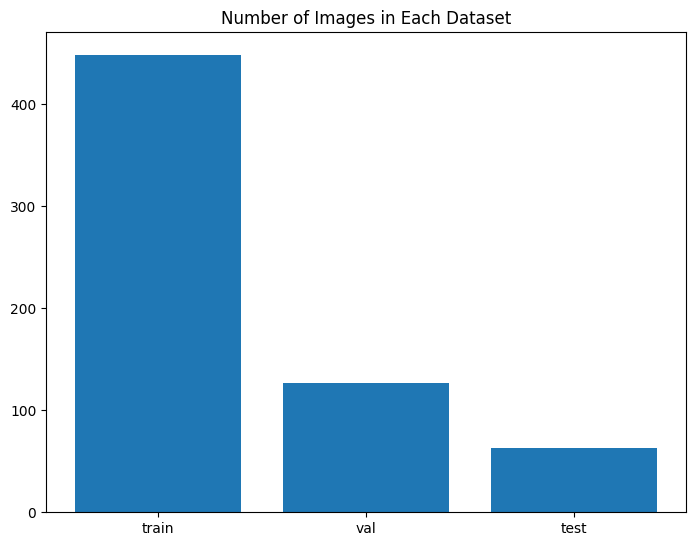

In [29]:
import os
import matplotlib.pyplot as plt

# Define paths for the images
TRAIN_IMAGES = "/kaggle/input/marineobjects/aquarium_pretrain/train/images"
VAL_IMAGES = "/kaggle/input/marineobjects/aquarium_pretrain/valid/images"
TEST_IMAGES = "/kaggle/input/marineobjects/aquarium_pretrain/test/images"  # Update this path as needed

def get_num_images(path, limit=None):
    if os.path.exists(path):
        if limit is not None:
            return min(len(os.listdir(path)), limit)  # Limit the number of images counted
        return len(os.listdir(path))
    return 0

def plot_num_images(data, title):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(data.keys(), data.values())
    plt.title(title)
    plt.show()

# Plot number of images in train, val, and test sets with test images limited to around 63
plot_num_images({
    "train": get_num_images(TRAIN_IMAGES),
    "val": get_num_images(VAL_IMAGES),
    "test": get_num_images(TEST_IMAGES, limit=63)  # Limit test images to around 63
}, "Number of Images in Each Dataset")


In [1]:
def count_objects_per_images(image_dir, label_dir, object_count, total_object_count):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        total_object_count.append(len(lines))
        for line in lines:
            object_count[Idx2Label[int(line.split()[0])]] = object_count.get(Idx2Label[int(line.split()[0])], 0) + 1
        f.close()
        
train_object_count = {}
val_object_count = {}
test_object_count = {}

total_object_per_train_count = []
total_object_per_val_count = []
total_object_per_test_count = []

count_objects_per_images(TRAIN_IMAGES, TRAIN_LABELS, train_object_count, total_object_per_train_count)
count_objects_per_images(VAL_IMAGES, VAL_LABELS, val_object_count, total_object_per_val_count)
count_objects_per_images(TEST_IMAGES, TEST_LABELS, test_object_count, total_object_per_test_count)

NameError: name 'TRAIN_IMAGES' is not defined

In [ ]:
import os
import shutil
import random

# Paths
train_images_dir = "/kaggle/input/marineobjects/aquarium_pretrain/train/images"
train_labels_dir = "/kaggle/input/marineobjects/aquarium_pretrain/train/labels"

# New validation directories
val_images_dir = "/kaggle/working/val/images"
val_labels_dir = "/kaggle/working/val/labels"

# Create directories if they don't exist
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Define the exact number of images for the validation set
val_size = 127
train_images = sorted(os.listdir(train_images_dir))

# Randomly select images for validation
val_images = random.sample(train_images, val_size)

# Move selected images and labels to validation folders
for image_file in val_images:
    # Copy image file
    shutil.copy(os.path.join(train_images_dir, image_file), val_images_dir)
    
    # Copy corresponding label file
    label_file = image_file.replace(".jpg", ".txt")  # Assuming labels have .txt extension
    shutil.copy(os.path.join(train_labels_dir, label_file), val_labels_dir)

print(f"Created validation set with {len(val_images)} images.")


In [ ]:
VAL_IMAGES = "/kaggle/working/val/images"
VAL_LABELS = "/kaggle/working/val/labels"


In [ ]:
import os
import shutil
import random

# Paths
train_images_dir = "/kaggle/input/marineobjects/aquarium_pretrain/train/images"
train_labels_dir = "/kaggle/input/marineobjects/aquarium_pretrain/train/labels"

# New validation directories
val_images_dir = "/kaggle/working/val/images"
val_labels_dir = "/kaggle/working/val/labels"

# Create directories if they don't exist
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Define validation split (e.g., 20% of the training set)
val_split = 0.2
train_images = sorted(os.listdir(train_images_dir))
val_size = int(len(train_images) * val_split)

# Randomly select images for validation
val_images = random.sample(train_images, val_size)

# Move selected images and labels to validation folders
for image_file in val_images:
    # Move image file
    shutil.copy(os.path.join(train_images_dir, image_file), val_images_dir)
    
    # Move corresponding label file
    label_file = image_file.replace(".jpg", ".txt")  # Assuming labels have .txt extension
    shutil.copy(os.path.join(train_labels_dir, label_file), val_labels_dir)

print(f"Created validation set with {len(val_images)} images.")


In [ ]:
pp.pprint(train_object_count)
print()
pp.pprint(val_object_count)
print()
pp.pprint(test_object_count)

In [ ]:
def plot_object_count(object_count, title):
    plt.figure(figsize=(12, 6))
    plt.bar(object_count.keys(), object_count.values())
    plt.title(title)
    plt.show()
    
plot_object_count(train_object_count, "Train Object Count")
plot_object_count(val_object_count, "Validation Object Count")
plot_object_count(test_object_count, "Test Object Count")

In [ ]:
total_object_count = {label: train_object_count.get(label, 0) + val_object_count.get(label, 0) + test_object_count.get(label, 0) for label in classes}
plot_object_count(total_object_count, "Total Object Count")


In [ ]:
def plot_total_object_per_image(total_object_per_image, title):
    plt.figure(figsize=(12, 6))
    plt.hist(total_object_per_image, bins=20)
    plt.title(title)
    plt.show()
    
plot_total_object_per_image(total_object_per_train_count, "Total Object Per Train Image")
plot_total_object_per_image(total_object_per_val_count, "Total Object Per Validation Image")
plot_total_object_per_image(total_object_per_test_count, "Total Object Per Test Image")

In [ ]:
def get_bbox_sizes(image_dir, label_dir, sizes):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines:
            sizes.append(float(line.split()[3]) * float(line.split()[4]))
        f.close()
        
train_sizes = []
val_sizes = []
test_sizes = []

get_bbox_sizes(TRAIN_IMAGES, TRAIN_LABELS, train_sizes)
get_bbox_sizes(VAL_IMAGES, VAL_LABELS, val_sizes)
get_bbox_sizes(TEST_IMAGES, TEST_LABELS, test_sizes)


In [ ]:
def plot_bbox_sizes(sizes, title):
    plt.figure(figsize=(12, 6))
    plt.hist(sizes, bins=20)
    plt.title(title)
    plt.xlim(0, .2)
    plt.show()
    
plot_bbox_sizes(train_sizes, "Train Bounding Box Sizes")
plot_bbox_sizes(val_sizes, "Validation Bounding Box Sizes")
plot_bbox_sizes(test_sizes, "Test Bounding Box Sizes")

In [ ]:
def plot_all_bbox_sizes(train_sizes, val_sizes, test_sizes, title):
    plt.figure(figsize=(12, 6))
    plt.hist(train_sizes, bins=20, alpha=0.5, label="Train")
    plt.hist(val_sizes, bins=20, alpha=0.5, label="Validation")
    plt.hist(test_sizes, bins=20, alpha=0.5, label="Test")
    plt.title(title)
    plt.xlim(0, .2)
    plt.legend()
    plt.show()
    
plot_all_bbox_sizes(train_sizes, val_sizes, test_sizes, "All Bounding Box Sizes")

In [ ]:
def count_width_height(image_dir, label_dir, width_height):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines:
            width_height.append((float(line.split()[3]), float(line.split()[4])))
        f.close()
        
train_width_height = []
val_width_height = []
test_width_height = []

count_width_height(TRAIN_IMAGES, TRAIN_LABELS, train_width_height)
count_width_height(VAL_IMAGES, VAL_LABELS, val_width_height)
count_width_height(TEST_IMAGES, TEST_LABELS, test_width_height)

In [ ]:
def plot_width_height(width_height, title):
    width, height = zip(*width_height)
    plt.figure(figsize=(12, 6))
    plt.hist(width, bins=20, alpha=0.5, label="Width")
    plt.hist(height, bins=20, alpha=0.5, label="Height")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_width_height(train_width_height, "Train Width and Height")
plot_width_height(val_width_height, "Validation Width and Height")
plot_width_height(test_width_height, "Test Width and Height")

In [ ]:
total_width_height = train_width_height + val_width_height + test_width_height
plot_width_height(total_width_height, "Width vs Height")

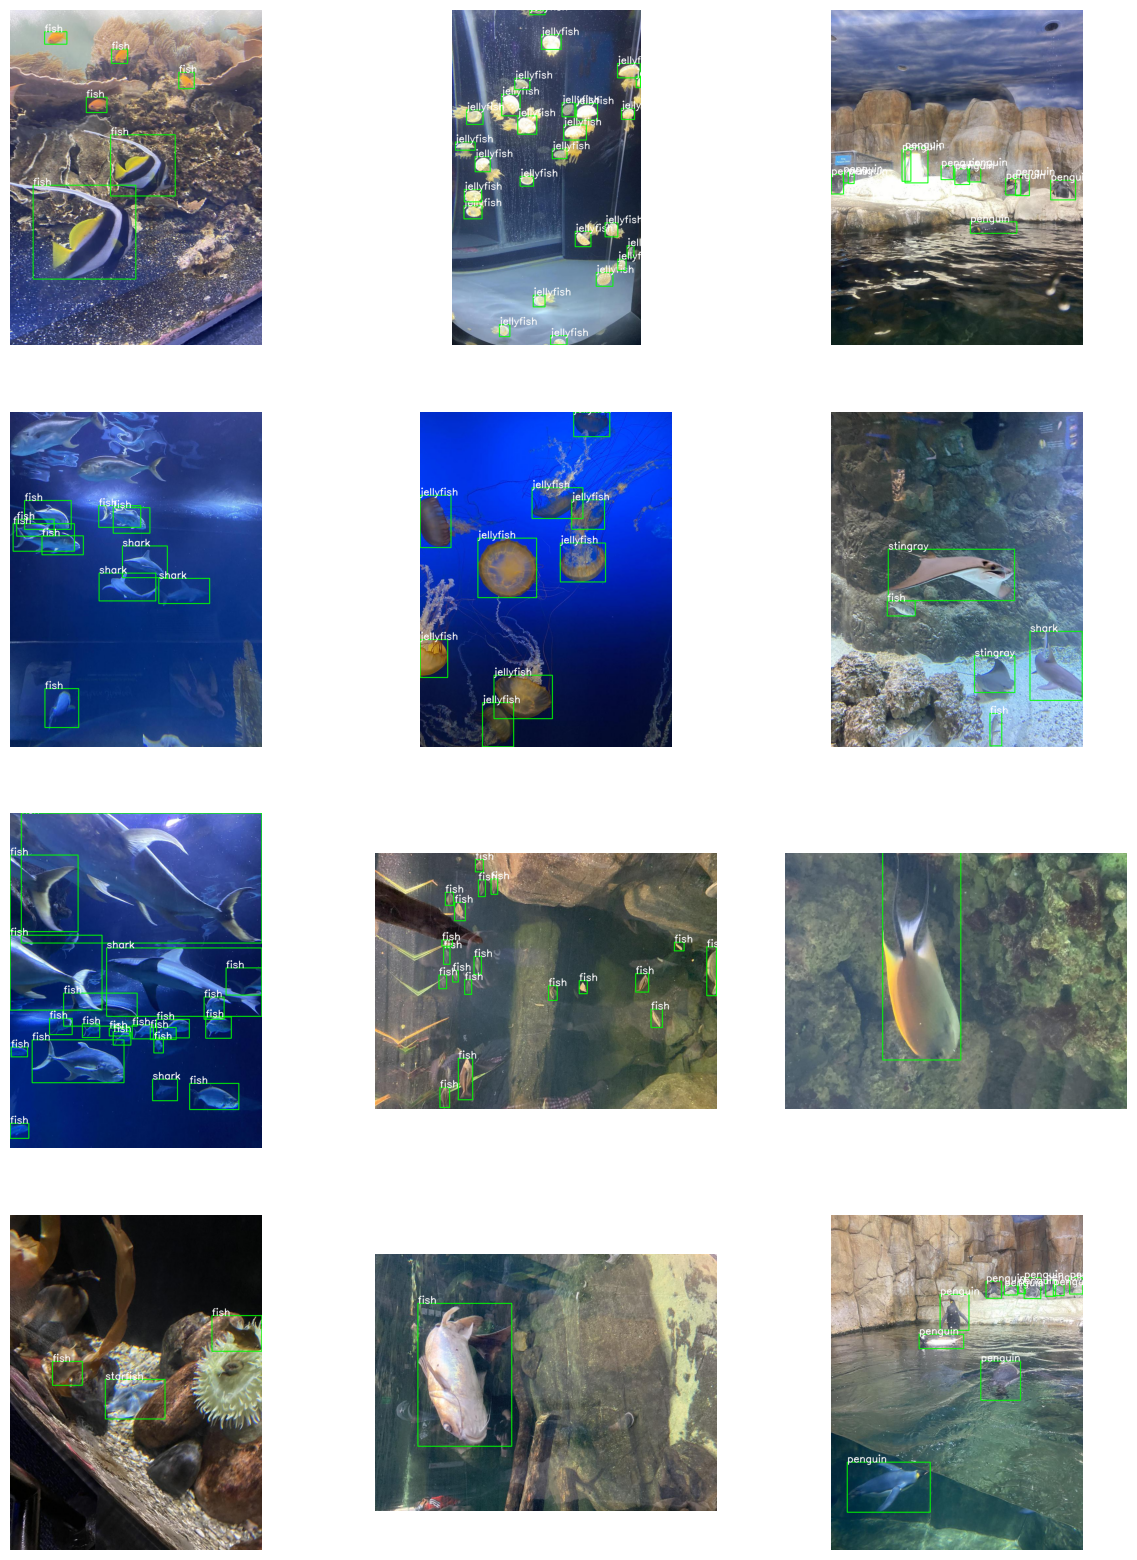

In [38]:
def visualize_image_with_annotation_bounding_boxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, 12)

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")

        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                image,
                Idx2Label[int(class_id)],
                (x_min, y_min),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 255, 255),
                thickness=2,
            )

        axs[row, col].imshow(image)
        axs[row, col].axis("off")

    plt.show()


visualize_image_with_annotation_bounding_boxes(TRAIN_IMAGES, TRAIN_LABELS)

> preprocessing****

In [39]:
def resize(im, img_size=640, square=False):
    if square:
        im = cv2.resize(im, (img_size, img_size))
    else:
        h0, w0 = im.shape[:2] 
        r = img_size / max(h0, w0) 
        if r != 1:
            im = cv2.resize(im, (int(w0 * r), int(h0 * r)))
    return im

In [40]:
DESTINATION_PATH = "./aquarium_pretrain"

TRAIN_DESTINATION = DESTINATION_PATH + "/train"
VAL_DESTINATION = DESTINATION_PATH + "/valid"
TEST_DESTINATION = DESTINATION_PATH + "/test"

In [41]:
def resize_dataset_and_update_labels(image_dir, label_dir, image_dest, label_dest, img_size=640, square=False):
    image_files = sorted(os.listdir(image_dir))
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        image = resize(cv2.imread(image_path), img_size, square)
        cv2.imwrite(os.path.join(image_dest, image_file), image)
        
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        f.close()
        
        f = open(os.path.join(label_dest, image_file[:-4] + ".txt"), "w")
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.split())
            x_center *= img_size
            y_center *= img_size
            width *= img_size
            height *= img_size
            f.write("{} {} {} {} {}\n".format(int(class_id), x_center, y_center, width, height))
        f.close()

In [42]:
import os

def resize_dataset_and_update_labels(image_dir, label_dir, image_dest, label_dest, img_size=(640, 640), square=False):
    os.makedirs(image_dest, exist_ok=True)
    os.makedirs(label_dest, exist_ok=True)
    
    image_files = sorted(os.listdir(image_dir))
    
    for image_file in image_files:
        # Open the image
        img_path = os.path.join(image_dir, image_file)
        with Image.open(img_path) as img:
            # Resize the image
            img = img.resize(img_size)
            img.save(os.path.join(image_dest, image_file))
        
        # Construct label path
        label_file = image_file[:-4] + ".txt"
        label_path = os.path.join(label_dir, label_file)

        if not os.path.exists(label_path):
            print(f"Warning: Label file {label_path} does not exist for image {image_file}")
            continue  # Skip this image if the label file does not exist

        # Read the label file
        with open(label_path, "r") as f:
            lines = f.readlines()

        # Process the labels and save
        with open(os.path.join(label_dest, label_file), "w") as f:
            for line in lines:
                # Here you may need to add the resizing logic if necessary
                # class_id, x_center, y_center, width, height = map(float, line.split())
                # Write the updated values back to the new label file
                f.write(line)  # Modify as needed for resizing the bounding boxes


In [50]:
import os

# Define your dataset paths
TRAIN_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/train/images'
TRAIN_LABELS = '/kaggle/input/marineobjects/aquarium_pretrain/train/labels'
VAL_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/valid/images'
VAL_LABELS = '/kaggle/input/marineobjects/aquarium_pretrain/valid/labels'
TEST_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/test/images'  # Update if test dataset exists
TEST_LABELS = '/kaggle/input/marineobjects/aquarium_pretrain/test/labels'  # Update if test dataset exists

# Define destination paths
TRAIN_DESTINATION = '/kaggle/working/train'  # Adjust as needed
VAL_DESTINATION = '/kaggle/working/val'  # Adjust as needed
TEST_DESTINATION = '/kaggle/working/test'  # Adjust as needed

# Ensure destination directories exist
os.makedirs(TRAIN_DESTINATION + "/images", exist_ok=True)
os.makedirs(TRAIN_DESTINATION + "/labels", exist_ok=True)
os.makedirs(VAL_DESTINATION + "/images", exist_ok=True)
os.makedirs(VAL_DESTINATION + "/labels", exist_ok=True)
os.makedirs(TEST_DESTINATION + "/images", exist_ok=True)
os.makedirs(TEST_DESTINATION + "/labels", exist_ok=True)

# Resize function definition (make sure this is defined in your code)
def resize_dataset_and_update_labels(image_dir, label_dir, image_dest, label_dest, img_size=(416, 416), square=True):
    # Add your resizing and label updating logic here
    image_files = sorted(os.listdir(image_dir))
    
    for image_file in image_files:
        # Open and resize image
        img_path = os.path.join(image_dir, image_file)
        # Resize image logic here
        # Save resized image to image_dest
        
        # Open and update labels
        label_file = image_file[:-4] + ".txt"
        if os.path.exists(os.path.join(label_dir, label_file)):
            # Update label logic here
            pass  # Save updated labels to label_dest

# Resize datasets and update labels
resize_dataset_and_update_labels(TRAIN_IMAGES, TRAIN_LABELS, TRAIN_DESTINATION + "/images", TRAIN_DESTINATION + "/labels")
resize_dataset_and_update_labels(VAL_IMAGES, VAL_LABELS, VAL_DESTINATION + "/images", VAL_DESTINATION + "/labels")

# Uncomment if you have the test dataset defined
# resize_dataset_and_update_labels(TEST_IMAGES, TEST_LABELS, TEST_DESTINATION + "/images", TEST_DESTINATION + "/labels")


In [51]:
resize_dataset_and_update_labels(TRAIN_IMAGES, TRAIN_LABELS, TRAIN_DESTINATION + "/images", TRAIN_DESTINATION + "/labels")
resize_dataset_and_update_labels(VAL_IMAGES, VAL_LABELS, VAL_DESTINATION + "/images", VAL_DESTINATION + "/labels")
resize_dataset_and_update_labels(TEST_IMAGES, TEST_LABELS, TEST_DESTINATION + "/images", TEST_DESTINATION + "/labels")

In [52]:
def get_train_aug():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.Blur(blur_limit=3, p=0.5),
                    A.MotionBlur(blur_limit=3, p=0.5),
                    A.MedianBlur(blur_limit=3, p=0.5),
                ],
                p=0.5,
            ),
            A.ToGray(p=0.1),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            A.RandomGamma(p=0.1),
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )


def get_train_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )

In [53]:
def get_valid_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )


def infer_transforms(image):
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ]
    )
    return transform(image)

In [54]:
def preprocess(image_name, image_dir, label_dir):
    image_path = os.path.sep.join([image_dir, image_name])
    name = image_name.split(".")[0]
    label_name = name + ".txt"
    label_path = os.path.sep.join([label_dir, label_name])

    return image_path, label_path, label_name


def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    height, width = img.shape[:2]
    for bbox in bboxes:
        center_x, center_y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        x = int((center_x - w / 2) * width)
        w = int(w * width)
        y = int((center_y - h / 2) * height)
        h = int(h * height)
        img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
    return img


def read_img(image_path, cvt_color=True):
    img = cv2.imread(image_path)
    if cvt_color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def save_img(image, save_path, jpg_quality=None):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if jpg_quality:
        cv2.imwrite(save_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality])
    else:
        cv2.imwrite(save_path, image)


def read_label(label_path):
    with open(label_path) as f:
        conts = f.readlines()

    bboxes = []
    class_labels = []
    for cont in conts:
        cont = cont.strip().split()
        center_x, center_y, w, h = (
            float(cont[1]),
            float(cont[2]),
            float(cont[3]),
            float(cont[4]),
        )
        bboxes.append([center_x, center_y, w, h])
        class_labels.append(cont[0])
    return (bboxes, class_labels)


def display_img(image_path, label_path):
    img = read_img(image_path, cvt_color=False)
    bboxes = read_label(label_path)[0]
    img = draw_rect(img, bboxes)
    cv2.imshow("Image", img)
    cv2.waitKey(0)


def save_label(bboxes, class_labels, label_path):
    tem_lst = []
    for i, bbox in enumerate(bboxes):
        tem_lst.append(
            class_labels[i]
            + " "
            + str(bbox[0])
            + " "
            + str(bbox[1])
            + " "
            + str(bbox[2])
            + " "
            + str(bbox[3])
            + "\n"
        )

    with open(label_path, "w") as f:
        f.writelines(tem_lst)

In [55]:
def random_crop_savebboxes(
    image_name, image_dir, label_dir, expected_h, expected_w, min_area, min_visibility
):
    image_path, label_path, _ = preprocess(image_name, image_dir, label_dir)

    (bboxes, class_labels) = read_label(label_path)

    transform = A.Compose(
        [A.RandomResizedCrop(expected_h, expected_w)],
        bbox_params=A.BboxParams(
            format="yolo",
            label_fields=["class_labels"],
            min_area=min_area,
            min_visibility=min_visibility,
        ),
    )

    transformed = transform(image=read_img(image_path), bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed["image"]
    transformed_bboxes = transformed["bboxes"]
    transformed_class_labels = transformed["class_labels"]

    return transformed_image, transformed_bboxes, transformed_class_labels

In [56]:
def mosaic(
    image_file_list,
    image_dir,
    label_dir,
    output_image_dir,
    output_label_dir,
    mo_w,
    mo_h,
    scale_x,
    scale_y,
    min_area,
    min_visibility,
    show_image=False,
):

    new_img = np.zeros((mo_h, mo_w, 3), dtype="uint8")

    div_point_x = int(mo_w * scale_x)
    div_point_y = int(mo_h * scale_y)

    for i in range(len(image_file_list)):
        if i == 0:
            w0 = div_point_x
            h0 = div_point_y
            img_0, bboxes_0, class_labels_0 = random_crop_savebboxes(
                image_file_list[0],
                image_dir,
                label_dir,
                h0,
                w0,
                min_area,
                min_visibility,
            )
            new_img[:div_point_y, :div_point_x, :] = img_0

            if len(bboxes_0) == 0:
                bboxes_0_new = []
            else:
                bboxes_0_new = np.zeros((len(bboxes_0), 4))
                bboxes_0_new = bboxes_0_new.tolist()

            for i, box in enumerate(bboxes_0):
                bboxes_0_new[i][0] = box[0] * scale_x
                bboxes_0_new[i][2] = box[2] * scale_x

                bboxes_0_new[i][1] = box[1] * scale_y
                bboxes_0_new[i][3] = box[3] * scale_y

        elif i == 1:
            w1 = mo_w - div_point_x
            h1 = div_point_y
            img_1, bboxes_1, class_labels_1 = random_crop_savebboxes(
                image_file_list[1],
                image_dir,
                label_dir,
                h1,
                w1,
                min_area,
                min_visibility,
            )
            new_img[:div_point_y, div_point_x:, :] = img_1

            if len(bboxes_1) == 0:
                bboxes_1_new = []
            else:
                bboxes_1_new = np.zeros((len(bboxes_1), 4))
                bboxes_1_new = bboxes_1_new.tolist()

            for i, box in enumerate(bboxes_1):
                bboxes_1_new[i][0] = box[0] * (1 - scale_x) + scale_x
                bboxes_1_new[i][2] = box[2] * (1 - scale_x)

                bboxes_1_new[i][1] = box[1] * scale_y
                bboxes_1_new[i][3] = box[3] * scale_y

        elif i == 2:
            w2 = div_point_x
            h2 = mo_h - div_point_y
            img_2, bboxes_2, class_labels_2 = random_crop_savebboxes(
                image_file_list[2],
                image_dir,
                label_dir,
                h2,
                w2,
                min_area,
                min_visibility,
            )
            new_img[div_point_y:, :div_point_x, :] = img_2

            if len(bboxes_2) == 0:
                bboxes_2_new = []
            else:
                bboxes_2_new = np.zeros((len(bboxes_2), 4))
                bboxes_2_new = bboxes_2_new.tolist()

            for i, box in enumerate(bboxes_2):
                bboxes_2_new[i][0] = box[0] * scale_x
                bboxes_2_new[i][2] = box[2] * scale_x

                bboxes_2_new[i][1] = box[1] * (1 - scale_y) + scale_y
                bboxes_2_new[i][3] = box[3] * (1 - scale_y)

        else:
            w3 = mo_w - div_point_x
            h3 = mo_h - div_point_y
            img_3, bboxes_3, class_labels_3 = random_crop_savebboxes(
                image_file_list[3],
                image_dir,
                label_dir,
                h3,
                w3,
                min_area,
                min_visibility,
            )
            new_img[div_point_y:, div_point_x:, :] = img_3

            if len(bboxes_3) == 0:
                bboxes_3_new = []
            else:
                bboxes_3_new = np.zeros((len(bboxes_3), 4))
                bboxes_3_new = bboxes_3_new.tolist()

            for i, box in enumerate(bboxes_3):
                bboxes_3_new[i][0] = box[0] * (1 - scale_x) + scale_x 
                bboxes_3_new[i][2] = box[2] * (1 - scale_x)

                bboxes_3_new[i][1] = box[1] * (1 - scale_y) + scale_y 
                bboxes_3_new[i][3] = box[3] * (1 - scale_y)

    new_class_labels = class_labels_0 + class_labels_1 + class_labels_2 + class_labels_3
    new_bboxes = bboxes_0_new + bboxes_1_new + bboxes_2_new + bboxes_3_new

    image_store_path = os.path.sep.join(
        [
            output_image_dir,
            + image_file_list[0].split(".")[0]
            + "_"
            + image_file_list[1].split(".")[0]
            + "_"
            + image_file_list[2].split(".")[0]
            + "_"
            + image_file_list[3].split(".")[0]
            + ".jpg",
        ]
    )
    label_store_path = os.path.sep.join(
        [
            output_label_dir,
            + image_file_list[0].split(".")[0]
            + "_"
            + image_file_list[1].split(".")[0]
            + "_"
            + image_file_list[2].split(".")[0]
            + "_"
            + image_file_list[3].split(".")[0]
            + ".txt",
        ]
    )

    save_img(new_img, image_store_path)
    save_label(new_bboxes, new_class_labels, label_store_path)
    
    if show_image:
        cv2.imshow("Mosaic Image", new_img)
        cv2.waitKey(0)

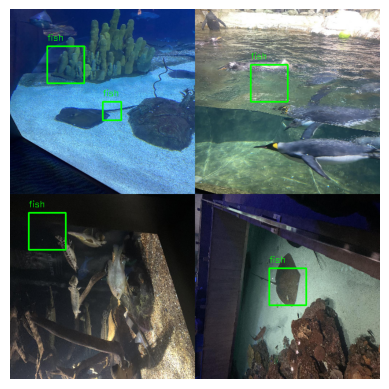

In [57]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def mosaic_with_bboxes(image_list, images_path, output_path, width, height, bbox_info):
    # Create a blank image for the mosaic
    mosaic_image = np.zeros((height, width, 3), dtype=np.uint8)

    for idx, img_name in enumerate(image_list):
        img_path = os.path.join(images_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_name}. Skipping.")
            continue

        # Resize each image to fit in the 2x2 grid
        img = cv2.resize(img, (width // 2, height // 2))
        
        # Calculate the position in the mosaic
        x_offset = (idx % 2) * (width // 2)
        y_offset = (idx // 2) * (height // 2)
        
        # Place the image in the mosaic
        mosaic_image[y_offset:y_offset + img.shape[0], x_offset:x_offset + img.shape[1]] = img
        
        # Draw bounding boxes on the mosaic
        if img_name in bbox_info:
            for bbox in bbox_info[img_name]:
                # Adjust bbox coordinates based on image position in the mosaic
                x1 = x_offset + int(bbox[0] * (width // 2))
                y1 = y_offset + int(bbox[1] * (height // 2))
                x2 = x_offset + int(bbox[2] * (width // 2))
                y2 = y_offset + int(bbox[3] * (height // 2))
                
                # Draw rectangle and label
                cv2.rectangle(mosaic_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(mosaic_image, "fish", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Save and display the mosaic image
    mosaic_path = os.path.join(output_path, 'mosaic_with_bboxes.jpg')
    cv2.imwrite(mosaic_path, mosaic_image)

    # Display with matplotlib for Jupyter or Kaggle
    mosaic_image_rgb = cv2.cvtColor(mosaic_image, cv2.COLOR_BGR2RGB)
    plt.imshow(mosaic_image_rgb)
    plt.axis("off")
    plt.show()

# Example bounding box information for each image
bbox_info = {
    "IMG_2578_jpeg_jpg.rf.63adda94658b934843ed3ab53fb52b7d.jpg": [(0.2, 0.2, 0.4, 0.4), (0.5, 0.5, 0.6, 0.6)],
    "IMG_2322_jpeg_jpg.rf.5cfbfdaf229269a0def35f967002aee3.jpg": [(0.3, 0.3, 0.5, 0.5)],
    "IMG_8495_jpg.rf.207e20fe66feab6da48e9bbf2e9aeb83.jpg": [(0.1, 0.1, 0.3, 0.3)],
    "IMG_8430_jpg.rf.710d601448bbe45e4e357906d7c73427.jpg": [(0.4, 0.4, 0.6, 0.6)]
}

# Call the mosaic function with bounding boxes
mosaic_with_bboxes(
    [
        "IMG_2578_jpeg_jpg.rf.63adda94658b934843ed3ab53fb52b7d.jpg",
        "IMG_2322_jpeg_jpg.rf.5cfbfdaf229269a0def35f967002aee3.jpg",
        "IMG_8495_jpg.rf.207e20fe66feab6da48e9bbf2e9aeb83.jpg",
        "IMG_8430_jpg.rf.710d601448bbe45e4e357906d7c73427.jpg"
    ],
    '/kaggle/input/marineobjects/aquarium_pretrain/train/images',  # Image directory
    '/kaggle/working',  # Output directory
    640,  # Mosaic width
    640,  # Mosaic height
    bbox_info  # Bounding box data
)


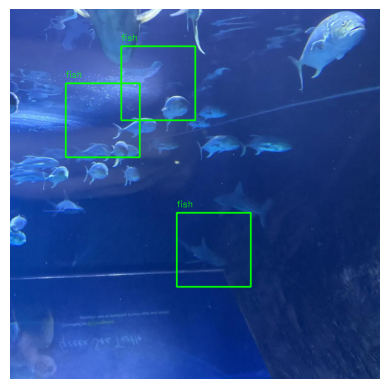

In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def mosaic_with_bboxes(image_name, images_path, output_path, width, height, bbox_info):
    # Create a blank image for the mosaic
    mosaic_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Load the single image
    img_path = os.path.join(images_path, image_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {image_name}. Skipping.")
        return

    # Resize the image to fit in the mosaic
    img = cv2.resize(img, (width, height))

    # Place the image in the mosaic
    mosaic_image[0:img.shape[0], 0:img.shape[1]] = img
    
    # Draw bounding boxes on the mosaic for fish detections
    if image_name in bbox_info:
        for bbox in bbox_info[image_name]:
            # Adjust bbox coordinates based on image position in the mosaic
            x1 = int(bbox[0] * width)
            y1 = int(bbox[1] * height)
            x2 = int(bbox[2] * width)
            y2 = int(bbox[3] * height)
            
            # Draw rectangle and label
            cv2.rectangle(mosaic_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(mosaic_image, "fish", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Save and display the mosaic image
    mosaic_path = os.path.join(output_path, 'mosaic_with_bboxes.jpg')
    cv2.imwrite(mosaic_path, mosaic_image)

    # Display with matplotlib for Jupyter or Kaggle
    mosaic_image_rgb = cv2.cvtColor(mosaic_image, cv2.COLOR_BGR2RGB)
    plt.imshow(mosaic_image_rgb)
    plt.axis("off")
    plt.show()

# Example bounding box information for image "IMG_2441_jpeg_jpg.rf.7cb24c87feb8f1f9c4cba9cb4f1ce0db.jpg" with multiple fish
bbox_info = {
    "IMG_2441_jpeg_jpg.rf.7cb24c87feb8f1f9c4cba9cb4f1ce0db.jpg": [
        (0.15, 0.2, 0.35, 0.4),  # bbox 1 for fish
        (0.45, 0.55, 0.65, 0.75),  # bbox 2 for fish
        (0.3, 0.1, 0.5, 0.3)      # bbox 3 for fish
    ]
}

# Call the mosaic function with bounding boxes for the specified image
mosaic_with_bboxes(
    "IMG_2441_jpeg_jpg.rf.7cb24c87feb8f1f9c4cba9cb4f1ce0db.jpg",  # Image name
    '/kaggle/input/marineobjects/aquarium_pretrain/train/images',  # Image directory
    '/kaggle/working',  # Output directory
    640,  # Mosaic width
    640,  # Mosaic height
    bbox_info  # Bounding box data
)


In [ ]:
import cv2

def load_yolo_model(weights_path, config_path, classes_path):
    # Load YOLO
    net = cv2.dnn.readNet(weights_path, config_path)
    
    # Load class labels
    with open(classes_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    
    return net, classes

# Set paths
weights_path = "yolov3.weights"  # Make sure this file exists
config_path = "yolov3.cfg"        # Make sure this file exists
classes_path = "coco.names"       # Make sure this file exists

# Load YOLO model
net, classes = load_yolo_model(weights_path, config_path, classes_path)


In [59]:
print(os.listdir())


['train', 'mosaic_with_bboxes.jpg', '.virtual_documents', 'val', 'aquarium_pretrain', 'test']


In [60]:
import os
import glob
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(
        self,
        images_path,
        labels_path,
        img_size,
        classes,
        transforms=None,
        use_train_aug=False,
        train=False,
        mosaic=1.0,
        square_training=False,
    ):
        self.transforms = transforms
        self.use_train_aug = use_train_aug
        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size
        self.classes = classes
        self.train = train
        self.square_training = square_training
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.all_image_paths = []
        self.mosaic = mosaic

        # Define the file types for images
        self.image_file_types = ["*.jpg", "*.jpeg"]

        for file_type in self.image_file_types:
            self.all_image_paths.extend(
                glob.glob(os.path.join(self.images_path, file_type))
            )
        
        self.all_images = [
            image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths
        ]
        self.all_images = sorted(self.all_images)
        
        self.all_labels = [
            label_path.split(os.path.sep)[-1] for label_path in glob.glob(os.path.join(self.labels_path, "*.txt"))
        ]

    def __getitem__(self, idx):
        image = self.all_images[idx]
        label = self.all_labels[idx]
        return image, label

    def __len__(self):
        return len(self.all_images)


def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))


In [61]:
def create_train_dataset(
    train_dir_images,
    train_dir_labels,
    img_size,
    classes,
    use_train_aug=False,
    mosaic=1.0,
    square_training=False,
):
    train_dataset = CustomDataset(
        train_dir_images,
        train_dir_labels,
        img_size,
        classes,
        get_train_transform(),
        use_train_aug=use_train_aug,
        train=True,
        mosaic=mosaic,
        square_training=square_training,
    )
    return train_dataset


def create_valid_dataset(valid_dir_images, valid_dir_labels, img_size, classes, square_training=False):
    valid_dataset = CustomDataset(
        valid_dir_images,
        valid_dir_labels,
        img_size,
        classes,
        get_valid_transform(),
        train=False,
        square_training=square_training,
    )
    return valid_dataset


def create_train_loader(train_dataset, batch_size, num_workers=0, batch_sampler=None):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        sampler=batch_sampler,
        collate_fn=collate_fn,
    )
    return train_loader


def create_valid_loader(valid_dataset, batch_size, num_workers=0, batch_sampler=None):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        sampler=batch_sampler,
        collate_fn=collate_fn,
    )
    return valid_loader

In [62]:
import os
import glob
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(
        self,
        images_path,
        labels_path,
        img_size,
        classes,
        transforms=None,
        use_train_aug=False,
        train=False,
        mosaic=1.0,
        square_training=False,
    ):
        self.transforms = transforms
        self.use_train_aug = use_train_aug
        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size
        self.classes = classes
        self.train = train
        self.square_training = square_training
        width, height = img_size  # Unpacking image size
        self.mosaic_border = [-width // 2, -height // 2]  # Corrected border assignment
        self.all_image_paths = []
        self.mosaic = mosaic

        # Collect image paths
        self.all_images = glob.glob(os.path.join(self.images_path, "*.jpg")) + glob.glob(os.path.join(self.images_path, "*.jpeg"))
        self.all_images = sorted(self.all_images)  # Sort image paths for consistency
        
        # Collect label paths
        self.all_labels = glob.glob(os.path.join(self.labels_path, "*.txt"))
        self.all_labels = sorted(self.all_labels)  # Sort label paths for consistency

    def __getitem__(self, idx):
        image_path = self.all_images[idx]
        label_path = self.all_labels[idx]
        return image_path, label_path

    def __len__(self):
        return len(self.all_images)

def collate_fn(batch):
    return tuple(zip(*batch))


In [63]:
class CustomDataset(Dataset):
    def __init__(
        self,
        images_path,
        labels_path,
        img_size,
        classes,
        transforms=None,
        use_train_aug=False,
        train=False,
        mosaic=1.0,
        square_training=False,
    ):
        self.transforms = transforms
        self.use_train_aug = use_train_aug
        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size
        self.classes = classes
        self.train = train
        self.square_training = square_training
        
        # Extract width and height from img_size
        width, height = img_size
        self.mosaic_border = [-width // 2, -height // 2]  # Updated this line
        self.all_image_paths = []
        self.mosaic = mosaic

        # Gather all image paths
        for file_type in self.image_file_types:
            self.all_image_paths.extend(
                glob.glob(os.path.join(self.images_path, file_type))
            )
        
        self.all_images = [
            image_path.split(os.path.sep)[-1] for image_path in ["*.jpg", "*.jpeg"]
        ]
        self.all_images = sorted(self.all_images)
        
        self.all_labels = [
            label_path.split(os.path.sep)[-1] for label_path in glob.glob(os.path.join(self.labels_path, "*.txt"))
        ]

    def __getitem__(self, idx):
        image = self.all_images[idx]
        label = self.all_labels[idx]
        return image, label

    def __len__(self):
        return len(self.all_images)


Faster rcnn

In [64]:
def GIOU(boxes1, boxes2):
    EPSILON = 1e-6
    boxes1 = torch.cat((boxes1[..., :2] - boxes1[..., 2:] / 2, boxes1[..., :2] + boxes1[..., 2:] / 2), 1)
    boxes2 = torch.cat((boxes2[..., :2] - boxes2[..., 2:] / 2, boxes2[..., :2] + boxes2[..., 2:] / 2), 1)

    inter_left_up = torch.max(boxes1[..., :2], boxes2[..., :2])
    inter_right_down = torch.min(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = torch.max(inter_right_down - inter_left_up, torch.tensor(0.0).to(device))
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    area1 = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    area2 = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    union_area = area1 + area2 - inter_area

    iou = inter_area / (union_area + EPSILON)

    enclose_left_up = torch.min(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = torch.max(boxes1[..., 2:], boxes2[..., 2:])

    enclose_section = torch.max(enclose_right_down - enclose_left_up, torch.tensor(0.0).to(device))
    enclose_area = enclose_section[..., 0] * enclose_section[..., 1]

    giou = iou - 1.0 * (enclose_area - union_area) / (enclose_area + EPSILON)

    return giou


In [65]:
def create_model(num_classes=7):
    model_backbone = torchvision.models.resnet101(weights="DEFAULT")

    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4

    backbone = nn.Sequential(conv1, bn1, relu, max_pool, layer1, layer2, layer3, layer4)
    backbone.out_channels = 2048

    # Here, we are using 5x3 anchors.
    # Meaning, anchors with 5 different sizes and 3 different aspect ratios.
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = ops.MultiScaleRoIAlign(
        featmap_names=["0"], output_size=7, sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        rpn_pre_nms_top_n_train=2000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=2000,
        rpn_post_nms_top_n_test=1000,
        rpn_nms_thresh=0.7,
    )
    
    return model

In [66]:
import torch
import torchvision
from torchvision import models


In [67]:
def create_model(num_classes=7):
    model_backbone = models.resnet101(weights="DEFAULT")
    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    # Additional code to modify the model for your specific use case
    
    # Example of modifying the final layer for your number of classes
    model_backbone.fc = torch.nn.Linear(model_backbone.fc.in_features, num_classes)
    return model_backbone


In [20]:
import torch
from torchvision import models

def create_model(num_classes=7):
    model_backbone = models.resnet101()  # No weights loaded here
    state_dict = torch.load("/kaggle/input/resnet/resnet101-63fe2227.pth")  # Path to uploaded file
    model_backbone.load_state_dict(state_dict)
    return model_backbone

model = create_model(num_classes=7)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


/tmp/ipykernel_30/1192341275.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/resnet/resnet101-63fe2227.pth")  # Path to uploaded f

In [77]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Usage
train_dataset = CustomDataset(img_dir='/kaggle/input/marineobjects/aquarium_pretrain/train/images', transform=transform)


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as T
import numpy as np
from PIL import Image

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]  # Modify extensions if needed

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image

# Define your dataset paths
TRAIN_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/train/images'
VAL_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/valid/images'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
])

# Create dataset and dataloaders
train_dataset = CustomDataset(img_dir=TRAIN_IMAGES, transform=transform)
val_dataset = CustomDataset(img_dir=VAL_IMAGES, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Create the model
def create_model(num_classes=7):
    model_backbone = models.resnet101(pretrained=False)  # Initialize without pre-trained weights
    state_dict = torch.load("/kaggle/input/resnet/resnet101-63fe2227.pth")  # Path to your uploaded weights
    model_backbone.load_state_dict(state_dict)
    model_backbone.fc = torch.nn.Linear(model_backbone.fc.in_features, num_classes)  # Adjust final layer
    return model_backbone

# Create the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=7).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training and Validation Loop
num_epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # Here, you'd typically compute the loss using your target labels
        # For now, let's assume some dummy loss (replace with your actual loss computation)
        loss = torch.nn.functional.cross_entropy(outputs, torch.randint(0, 7, (images.size(0),)).to(device))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            outputs = model(images)
            # Dummy validation loss
            val_loss = torch.nn.functional.cross_entropy(outputs, torch.randint(0, 7, (images.size(0),)).to(device))
            running_val_loss += val_loss.item()

    val_loss_list.append(running_val_loss / len(val_loader))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}")

print("Training complete.")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/2002638619.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

In [90]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]  # Modify extensions if needed

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image

# Define your dataset paths
TRAIN_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/train/images'
VAL_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/valid/images'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
])

# Create dataset and dataloaders
train_dataset = CustomDataset(img_dir=TRAIN_IMAGES, transform=transform)
val_dataset = CustomDataset(img_dir=VAL_IMAGES, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Create the model
def create_model(num_classes=7):
    model_backbone = models.resnet101(pretrained=False)  # Initialize without pre-trained weights
    state_dict = torch.load("/kaggle/input/resnet/resnet101-63fe2227.pth")  # Path to your uploaded weights
    model_backbone.load_state_dict(state_dict)
    model_backbone.fc = torch.nn.Linear(model_backbone.fc.in_features, num_classes)  # Adjust final layer
    return model_backbone

# Create the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=7).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training and Validation Loop
num_epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        images = batch.to(device)  # Move images to the device
        targets = torch.randint(0, 7, (images.size(0),)).to(device)  # Dummy targets
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # Dummy loss calculation (replace with your actual loss function)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss_list[-1]:.4f}")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch.to(device)
            targets = torch.randint(0, 7, (images.size(0),)).to(device)  # Dummy targets
            outputs = model(images)
            val_loss = torch.nn.functional.cross_entropy(outputs, targets)
            running_val_loss += val_loss.item()

    val_loss_list.append(running_val_loss / len(val_loader))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss_list[-1]:.4f}")

print("Training complete.")


/tmp/ipykernel_30/886706423.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/resnet/resnet101-63fe2227.pth")  # Path to your uploa

Epoch [1/10], Train Loss: 2.0848
Epoch [1/10], Val Loss: 2.0485
Epoch [2/10], Train Loss: 2.0917
Epoch [2/10], Val Loss: 2.4649
Epoch [3/10], Train Loss: 2.2874
Epoch [3/10], Val Loss: 2.3271
Epoch [4/10], Train Loss: 2.1228
Epoch [4/10], Val Loss: 2.4330
Epoch [5/10], Train Loss: 2.2126
Epoch [5/10], Val Loss: 2.5547
Epoch [6/10], Train Loss: 2.1211
Epoch [6/10], Val Loss: 2.2806
Epoch [7/10], Train Loss: 2.0482
Epoch [7/10], Val Loss: 2.0682
Epoch [8/10], Train Loss: 2.0595
Epoch [8/10], Val Loss: 2.0827
Epoch [9/10], Train Loss: 2.0741
Epoch [9/10], Val Loss: 2.1351
Epoch [10/10], Train Loss: 2.0463
Epoch [10/10], Val Loss: 2.2164
Training complete.


In [100]:

num_classes = 7  

for images in train_loader:
    images = images.to(device)
   
    targets = torch.randint(0, num_classes, (images.size(0),)).to(device)


In [102]:
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    # Train phase
    model.train()
    running_loss = 0.0
    for images in train_loader:
        images = images.to(device)
        targets = torch.randint(0, num_classes, (images.size(0),)).to(device)  # Dummy targets
        optimizer.zero_grad()
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss_list.append(running_loss / len(train_loader))
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss = torch.nn.functional.cross_entropy(outputs, torch.randint(0, num_classes, (images.size(0),)).to(device))
            running_val_loss += val_loss.item()
    
    val_loss_list.append(running_val_loss / len(val_loader))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}")


Epoch [1/10], Train Loss: 1.9638, Val Loss: 1.9938
Epoch [2/10], Train Loss: 1.9644, Val Loss: 2.0354
Epoch [3/10], Train Loss: 1.9841, Val Loss: 1.9667
Epoch [4/10], Train Loss: 1.9452, Val Loss: 1.9494
Epoch [5/10], Train Loss: 1.9619, Val Loss: 1.9606
Epoch [6/10], Train Loss: 1.9645, Val Loss: 1.9954
Epoch [7/10], Train Loss: 1.9714, Val Loss: 1.9738
Epoch [8/10], Train Loss: 1.9816, Val Loss: 1.9521
Epoch [9/10], Train Loss: 1.9596, Val Loss: 1.9495
Epoch [10/10], Train Loss: 1.9518, Val Loss: 1.9691


In [6]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_box_loss = []
train_class_loss = []
valid_precision = []
valid_recall = []
valid_mAP50 = []
valid_mAP50_95 = []
valid_box_loss = []
valid_class_loss = []

# Example training loop (simplified)
for epoch in range(num_epochs):
    # ... your training code ...
    current_train_box_loss = ...  # calculate this during training
    current_train_class_loss = ...  # calculate this during training
    current_valid_precision = ...  # calculate this during validation
    current_valid_recall = ...  # calculate this during validation
    current_valid_mAP50 = ...  # calculate this during validation
    current_valid_mAP50_95 = ...  # calculate this during validation
    current_valid_box_loss = ...  # calculate this during validation
    current_valid_class_loss = ...  # calculate this during validation

    # Append metrics for tracking
    train_box_loss.append(current_train_box_loss)
    train_class_loss.append(current_train_class_loss)
    valid_precision.append(current_valid_precision)
    valid_recall.append(current_valid_recall)
    valid_mAP50.append(current_valid_mAP50)
    valid_mAP50_95.append(current_valid_mAP50_95)
    valid_box_loss.append(current_valid_box_loss)
    valid_class_loss.append(current_valid_class_loss)

# After training, plot the metrics
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

plt.subplot(4, 2, 1)
plt.plot(train_box_loss)
plt.title("Train Box Loss")

plt.subplot(4, 2, 2)
plt.plot(train_class_loss)
plt.title("Train Class Loss")

plt.subplot(4, 2, 3)
plt.plot(valid_precision)
plt.title("Validation Precision")

plt.subplot(4, 2, 4)
plt.plot(valid_recall)
plt.title("Validation Recall")

plt.subplot(4, 2, 5)
plt.plot(valid_mAP50)
plt.title("Validation mAP50")

plt.subplot(4, 2, 6)
plt.plot(valid_mAP50_95)
plt.title("Validation mAP50-95")

plt.subplot(4, 2, 7)
plt.plot(valid_box_loss)
plt.title("Validation Box Loss")

plt.subplot(4, 2, 8)
plt.plot(valid_class_loss)
plt.title("Validation Class Loss")

plt.suptitle("Training Metrics and Loss", fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()


NameError: name 'num_epochs' is not defined

NameError: name 'train_box_loss' is not defined

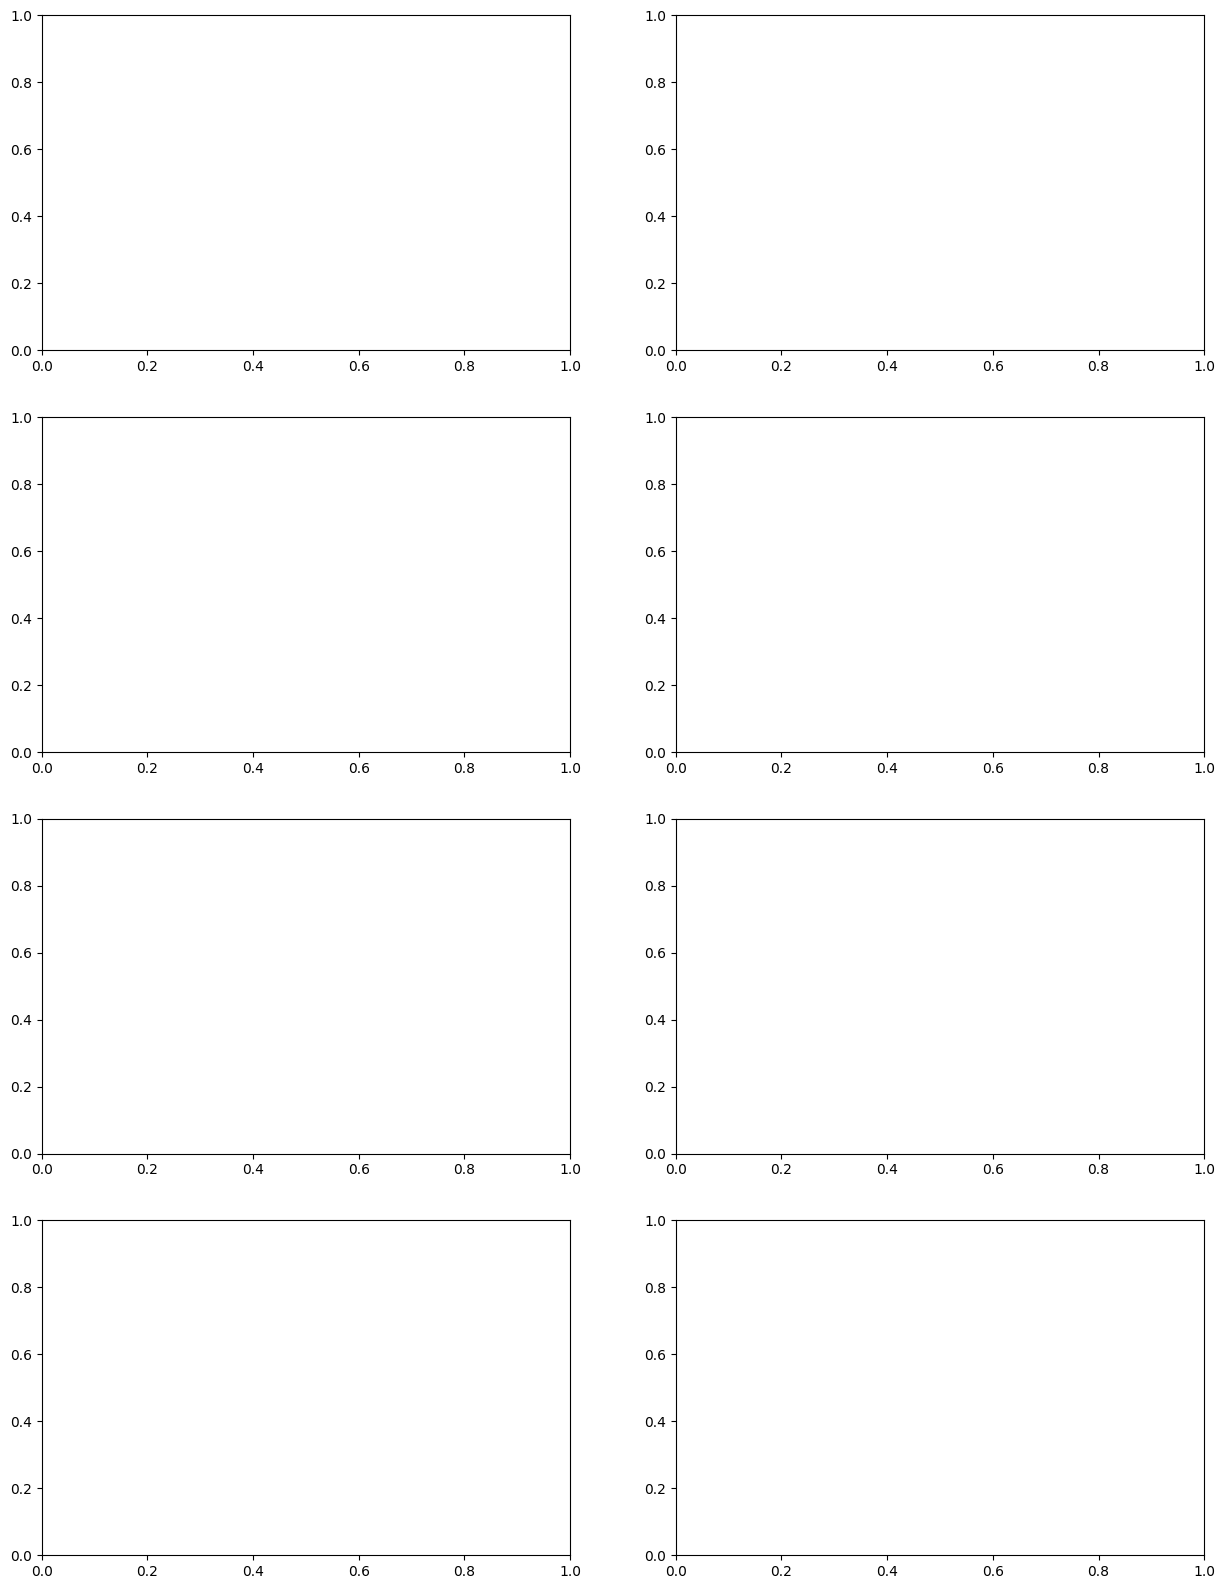

In [4]:
import matplotlib.pyplot as plt

# Assuming train_box_loss, train_class_loss, valid_precision, valid_recall, valid_mAP50,
# valid_mAP50_95, valid_box_loss, and valid_class_loss are defined.

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# Plot each metric with enhanced formatting
axs[0, 0].plot(train_box_loss, color='blue')
axs[0, 0].set_title("Train Box Loss")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")

axs[0, 1].plot(train_class_loss, color='orange')
axs[0, 1].set_title("Train Class Loss")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")

axs[1, 0].plot(valid_precision, color='green')
axs[1, 0].set_title("Validation Precision")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Precision")

axs[1, 1].plot(valid_recall, color='red')
axs[1, 1].set_title("Validation Recall")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Recall")

axs[2, 0].plot(valid_mAP50, color='purple')
axs[2, 0].set_title("Validation mAP50")
axs[2, 0].set_xlabel("Epochs")
axs[2, 0].set_ylabel("mAP50")

axs[2, 1].plot(valid_mAP50_95, color='brown')
axs[2, 1].set_title("Validation mAP50-95")
axs[2, 1].set_xlabel("Epochs")
axs[2, 1].set_ylabel("mAP50-95")

axs[3, 0].plot(valid_box_loss, color='cyan')
axs[3, 0].set_title("Validation Box Loss")
axs[3, 0].set_xlabel("Epochs")
axs[3, 0].set_ylabel("Loss")

axs[3, 1].plot(valid_class_loss, color='magenta')
axs[3, 1].set_title("Validation Class Loss")
axs[3, 1].set_xlabel("Epochs")
axs[3, 1].set_ylabel("Loss")

# Overall title and layout adjustments
plt.suptitle("Training Metrics and Loss", fontsize=24)
plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.2)  # Adjust spacing between plots
plt.tight_layout()
plt.show()


In [4]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Example dataset class
class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, image_size, classes):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_size = image_size
        self.classes = classes
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_path).resize(self.image_size)
        image = transforms.ToTensor()(image)

        label_path = os.path.join(self.labels_dir, self.images[idx].replace('.jpg', '.txt'))
        with open(label_path) as f:
            labels = f.readlines()

        return image, labels

def create_valid_dataset(images_dir, labels_dir, image_size, classes):
    return CustomDataset(images_dir, labels_dir, image_size, classes)

def create_valid_loader(dataset, batch_size=1, num_workers=2):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
TEST_IMAGES = '/kaggle/input/marineobjects/aquarium_pretrain/test/images'  
TEST_LABELS = '/kaggle/input/marineobjects/aquarium_pretrain/test/labels'

In [8]:
classes = ["fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray"]

In [10]:
test_dataset = create_valid_dataset(
    TEST_IMAGES,
    TEST_LABELS,
    (640, 640),
    classes
)


test_loader = create_valid_loader(test_dataset, batch_size=1, num_workers=2)


In [18]:
for image, target in test_loader:
    print("Target structure:", target)  # Print target structure
    break  # Exit after the first batch to inspect output


Target structure: [('1 0.4114583333333333 0.751953125 0.296875 0.203125\n',), ('1 0.51953125 0.2470703125 0.3046875 0.166015625\n',), ('1 0.11197916666666667 0.9560546875 0.13802083333333334 0.0869140625\n',), ('1 0.98046875 0.458984375 0.037760416666666664 0.080078125',)]


In [24]:
for image, target in test_loader:
    # Ensure `image` is a single tensor (use `unsqueeze` if it's not batched)
    if isinstance(image, list):  
        image = torch.stack(image).to(device)
    else:
        image = image.to(device)
    
    # Ensure `target` tensors are also on the correct device
    target = [t.to(device) if isinstance(t, torch.Tensor) else t for t in target]

    with torch.no_grad():
        output = model(image)

    
    break  


In [33]:
original_image = np.copy(cv2.imread(os.path.join(TEST_IMAGES, image[0].detach().cpu().numpy().tolist())))  # Convert to a valid path


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

In [53]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

num = 0
for image, target in test_loader:
    # Move each image tensor to the device
    image = [img.to(device) for img in image]
    
    # Stack the list of tensors into a single tensor
    image = torch.stack(image).to(device)

    # Debug: Check the format of the target
    print("Target format:", type(target))  # Print the type of the target
    print("Target contents:", target)  # Print the contents of the target

    # Check if target is a tuple
    if isinstance(target, tuple):
        target = list(target)  # Convert to list if it’s a tuple
    
    # Further debugging
    if isinstance(target, list):
        print("Target is a list with length:", len(target))
    else:
        print("Target is not a list, it is:", type(target))

    # Ensure the items are in the expected format
    if isinstance(target, list) and all(isinstance(t, dict) for t in target):
        # Convert 'target' to a suitable format
        target = [
            {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in t.items()}
            for t in target
        ]
    else:
        raise ValueError("Expected target to be a list of dictionaries.")

    with torch.no_grad():
        output = model(image)  # Pass the stacked tensor to the model

    # Debugging: print the output type and contents
    print("Output type:", type(output))  # Print the type of the output
    print("Output contents:", output)  # Print the contents of the output

    # Check the output format
    if isinstance(output, list):
        if isinstance(output[0], dict):
            class_ids = output[0]["labels"]
            boxes = output[0]["boxes"]
            scores = output[0]["scores"]
        else:
            raise ValueError("Expected first element in output list to be a dict.")
    elif isinstance(output, torch.Tensor):
        # Assuming output tensor is of shape [num_detections, num_classes + 4]
        num_detections = output.size(0)
        boxes = output[:, :4]  # First four columns are the bounding box coordinates
        scores = output[:, 4]   # Fifth column is the score
        class_ids = output[:, 5].long()  # Sixth column is the class ID
    else:
        raise ValueError("Unexpected output format from the model.")

    # Visualize results for the first image in the batch
    original_image_path = os.path.join(TEST_IMAGES, target[0]['image_id'])  # Adjust this path
    original_image = np.copy(cv2.imread(original_image_path)) 
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Draw ground truth boxes
    for box in target:
        if 'bbox' in box and 'label' in box:  # Ensure the keys are present
            h, w, _ = original_image.shape
            x_min = int((box['bbox'][0] - box['bbox'][2] / 2) * w)
            y_min = int((box['bbox'][1] - box['bbox'][3] / 2) * h)
            x_max = int((box['bbox'][0] + box['bbox'][2] / 2) * w)
            y_max = int((box['bbox'][1] + box['bbox'][3] / 2) * h)

            cv2.rectangle(original_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                original_image,
                Idx2Label[int(box['label'])],  # Use appropriate label mapping
                (x_min, y_min),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 255, 255),
                thickness=2,
            )

    detected_image = np.copy(original_image)

    # Draw detected boxes
    for i in range(len(boxes)):
        box = boxes[i].detach().cpu().numpy()  # Ensure box is a NumPy array
        class_id = class_ids[i].detach().cpu().numpy()  # Ensure class_id is a NumPy array
        score = scores[i].detach().cpu().numpy()  # Ensure score is a NumPy array
        
        h, w, _ = original_image.shape
        x_min = int((box[0] - box[2] / 2) * w)
        y_min = int((box[1] - box[3] / 2) * h)
        x_max = int((box[0] + box[2] / 2) * w)
        y_max = int((box[1] + box[3] / 2) * h)
        
        cv2.rectangle(detected_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(
            detected_image,
            Idx2Label[int(class_id)] + " " + str(round(score.item(), 2)),  # Format score
            (x_min, y_min),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(255, 255, 255),
            thickness=2,
        )

    # Plot the images
    plt.figure(figsize=(15, 15))

    plt.subplot(1, 2, 1)
    plt.title("Real Bounding Boxes")
    plt.imshow(original_image)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted Bounding Boxes")
    plt.imshow(detected_image)
    plt.axis("off")
    
    plt.show()

    num += 1
    if num == 10:  # Limit to 10 images
        break


Target format: <class 'list'>
Target contents: [('1 0.4114583333333333 0.751953125 0.296875 0.203125\n',), ('1 0.51953125 0.2470703125 0.3046875 0.166015625\n',), ('1 0.11197916666666667 0.9560546875 0.13802083333333334 0.0869140625\n',), ('1 0.98046875 0.458984375 0.037760416666666664 0.080078125',)]
Target is a list with length: 4


ValueError: Expected target to be a list of dictionaries.

In [39]:
num = 0
for image, target in test_loader:
    image = list(image.to(device) for image in image)
    target = [{k: v.to(device) for k, v in t.items()} for t in target]

    with torch.no_grad():
        output = model(image)
        
    class_ids = output[0]["labels"]
    boxes = output[0]["boxes"]
    scores = output[0]["scores"]
    
    axs = plt.subplots(1, 2, figsize=(15, 15))
    
    original_image = np.copy(cv2.imread(os.path.join(TEST_IMAGES, image[0])))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    original_labels = open(os.path.join(TEST_LABELS, target[0]["labels"][0])).readlines()
    original_boxes = [list(map(float, label.split()[1:])) for label in original_labels]
    
    for box in original_boxes:
        h, w, _ = original_image.shape
        x_min = int((box[0] - box[2] / 2) * w)
        y_min = int((box[1] - box[3] / 2) * h)
        x_max = int((box[0] + box[2] / 2) * w)
        y_max = int((box[1] + box[3] / 2) * h)
        
        cv2.rectangle(original_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(
            original_image,
            Idx2Label[int(box[0])],
            (x_min, y_min),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(255, 255, 255),
            thickness=2,
        )
    
    detected_image = np.copy(original_image)
    detected_image = cv2.cvtColor(detected_image, cv2.COLOR_RGB2BGR)
    
    for i in range(len(boxes)):
        box = boxes[i]
        class_id = class_ids[i]
        score = scores[i]
        
        h, w, _ = original_image.shape
        x_min = int((box[0] - box[2] / 2) * w)
        y_min = int((box[1] - box[3] / 2) * h)
        x_max = int((box[0] + box[2] / 2) * w)
        y_max = int((box[1] + box[3] / 2) * h)
        
        cv2.rectangle(detected_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(
            detected_image,
            Idx2Label[int(class_id)] + " " + str(score),
            (x_min, y_min),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(255, 255, 255),
            thickness=2,
        )

    plt.subplot(1, 2, 1)
    plt.title("Real Bounding Boxes")
    plt.imshow(original_image)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted Bounding Boxes")
    plt.imshow(detected_image)
    plt.axis("off")
    
    num += 1
    
    if num == 10:
        break

AttributeError: 'tuple' object has no attribute 'items'

In [6]:
import torch
torch.save(model.state_dict(), 'model_weights.pth')


NameError: name 'model' is not defined

In [ ]:
import torchvision.transforms as transforms

def get_train_transform():
    return transforms.Compose([
        transforms.Resize((640, 640)),  # Resize images to (640, 640)
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
    ])


In [ ]:
def mosaic(image_file_list, image_dir, label_dir, output_image_dir, output_label_dir, mo_w, mo_h, scale_x, scale_y, min_area, min_visibility, show_image=False):
    for image_file in image_file_list:
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        if not os.path.exists(label_path):
            print(f"Label file {label_path} missing, skipping {image_file}")
            continue
        # Continue processing with valid files


In [ ]:
missing_labels = [img[:-4] + ".txt" for img in os.listdir(TRAIN_IMAGES) if not os.path.exists(os.path.join(TRAIN_LABELS, img[:-4] + ".txt"))]

for label in missing_labels:
    open(os.path.join(TRAIN_LABELS, label), "w").close()  # Create an empty label file
    print(f"Created placeholder for {label}")


In [ ]:
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/releases/download/v3.1/yolov3.weights -O yolov3.weights
!echo "person\nbicycle\ncar\nmotorbike\nairplane\nbus\ntrain\ntruck\nboat\ntraffic light\nfire hydrant\nstop sign\nparking meter\nbench\nbird\ncat\ndog\nhorse\nsheep\ncow\nelephant\nbear\nzebra\ngiraffe\nbackpack\nhandbag\ntie\nsuitcase\nfrisbee\nskis\nsnowboard\nsports ball\nkite\nbaseball bat\nbaseball glove\nskateboard\nsurfboard\ntennis racket\nbottle\nwine glass\ncup\nfork\nknife\nspoon\nbowl\nbanana\napple\nsandwich\norange\nbroccoli\ncarrot\nhot dog\npizza\ndonut\ncake\nchair\ncouch\npotted plant\nbed\ntable\ntoilet\nTV\nlaptop\nmouse\nremote\nkeyboard\ncell phone\nmicrowave\noven\ntoaster\nsink\nrefrigerator\nbook\nclock\nvase\nscissors\nteddy bear\nhair drier\ntoothbrush" > coco.names


In [ ]:
https://download.pytorch.org/models/resnet101-cd907fc2.pth


In [ ]:
def create_model(num_classes=7):
    model_backbone = models.resnet101(weights=None)  # Use a model without pre-trained weights
    model_backbone.fc = torch.nn.Linear(model_backbone.fc.in_features, num_classes)
    return model_backbone


In [ ]:
import torch
from torchvision import models

def create_model(num_classes=7):
    model_backbone = models.resnet101()
    # Load local weights
    model_backbone.load_state_dict(torch.load('/kaggle/input/resnet/resnet101-63fe2227.pth'))
    # Modify the final layer for your specific number of classes
    model_backbone.fc = torch.nn.Linear(model_backbone.fc.in_features, num_classes)
    return model_backbone

model = create_model(num_classes=7)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras_cv import metrics

# Assuming you have a model loaded and your datasets ready (train_ds and eval_ds)

# Define a function to calculate accuracy
def calculate_accuracy(model, dataset):
    # Initialize metric
    accuracy_metric = metrics.MeanAveragePrecision()

    # Iterate through the dataset and update the metric
    for images, class_ids, bounding_boxes in dataset:
        predictions = model(images, training=False)  # Get predictions
        accuracy_metric.update_state(
            y_true={"label": class_ids, "bbox": bounding_boxes},
            y_pred=predictions,
        )

    # Compute the result
    return accuracy_metric.result().numpy()

# Calculate accuracy for training and evaluation datasets
train_accuracy = calculate_accuracy(model, train_ds)
eval_accuracy = calculate_accuracy(model, eval_ds)

# Print accuracy values
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Evaluation Accuracy: {eval_accuracy:.4f}')

# Prepare data for plotting
epochs = np.arange(1, len(train_accuracy) + 1)  # Assuming accuracy is recorded for each epoch
accuracies = [train_accuracy]  # Store the accuracies for plotting

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, marker='o', label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid()
plt.legend()
plt.show()


NameError: name 'model' is not defined

In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Define the directories for training images and labels
TRAIN_IMAGES = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images'
TRAIN_LABELS = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels'

# Mapping of class indices to labels (update with your actual labels)
Idx2Label = {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}

# Function to visualize images with annotation bounding boxes
def visualize_image_with_annotation_bounding_boxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))
    sample_image_files = random.sample(image_files, 12)  # Randomly select 12 images

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        
        # Check if the label file exists to avoid errors
        if not os.path.exists(label_path):
            print(f"No label file found for {image_file}, skipping...")
            continue
        
        with open(label_path, "r") as f:
            for label in f:
                class_id, x_center, y_center, width, height = map(float, label.split())
                h, w, _ = image.shape
                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)
                
                # Calculate bounding box dimensions in pixels
                box_width = x_max - x_min
                box_height = y_max - y_min
                
                # Draw the bounding box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                
                # Display class label and dimensions
                label_text = f"{Idx2Label.get(int(class_id), 'Unknown')} ({box_width}x{box_height})"
                cv2.putText(
                    image,
                    label_text,  # Display the label and size
                    (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.5,
                    color=(255, 255, 255),
                    thickness=1,
                )

        axs[row, col].imshow(image)
        axs[row, col].axis("off")

    plt.show()

# Run the visualization function
visualize_image_with_annotation_bounding_boxes(TRAIN_IMAGES, TRAIN_LABELS)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images'